In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

# Exploratory Data Analysis & Preprocessing

In [2]:
df = pd.read_csv('data/spaceship_titanic.csv')
df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Initial notes:

- The 'PassengerId' and 'Name' columns seems unnecessary and can be dropped.
- All predictors seem to have missing values.

In [4]:
df.drop(['PassengerId', 'Name'], axis=1, inplace=True)

In [5]:
df.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

Notes:

- Outlier values seem very likely.

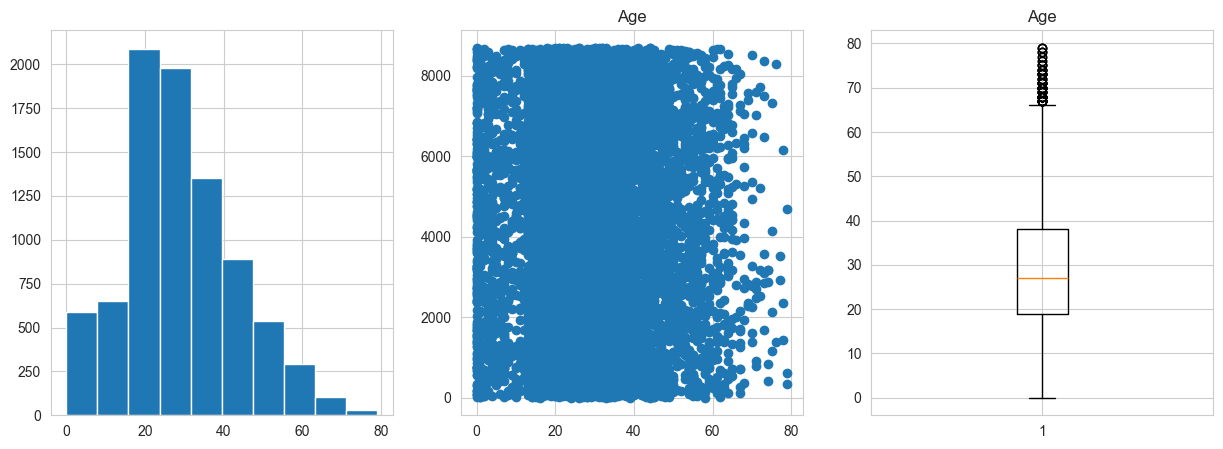

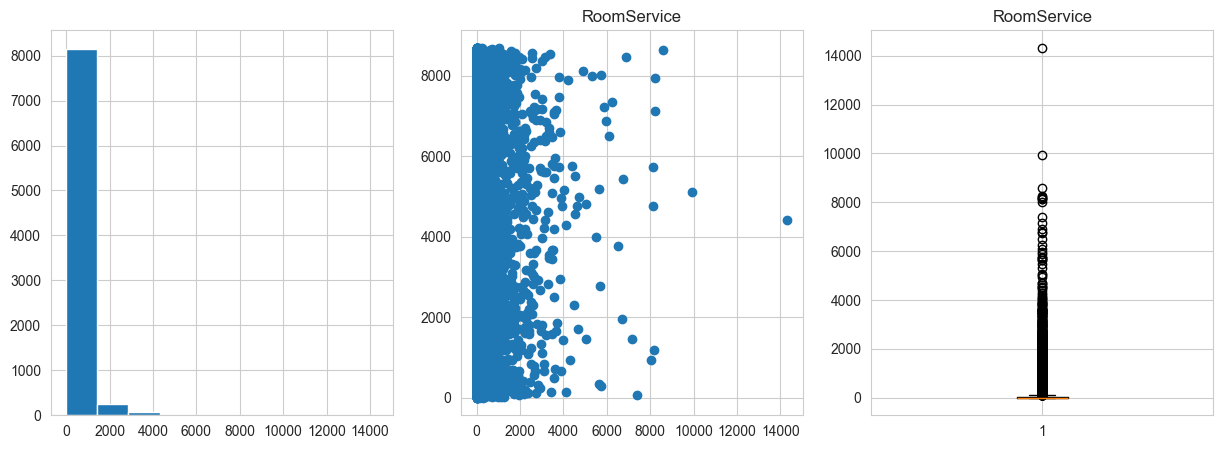

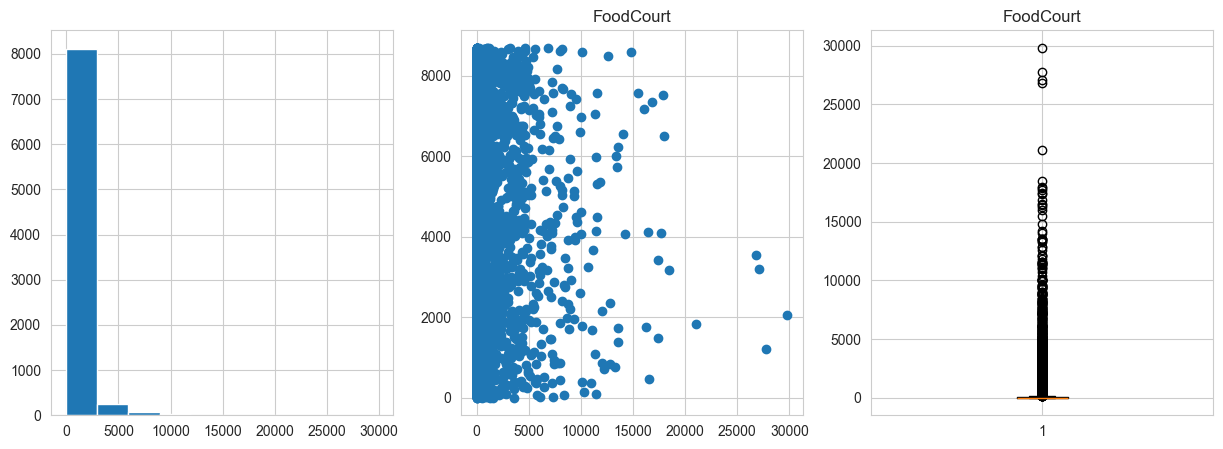

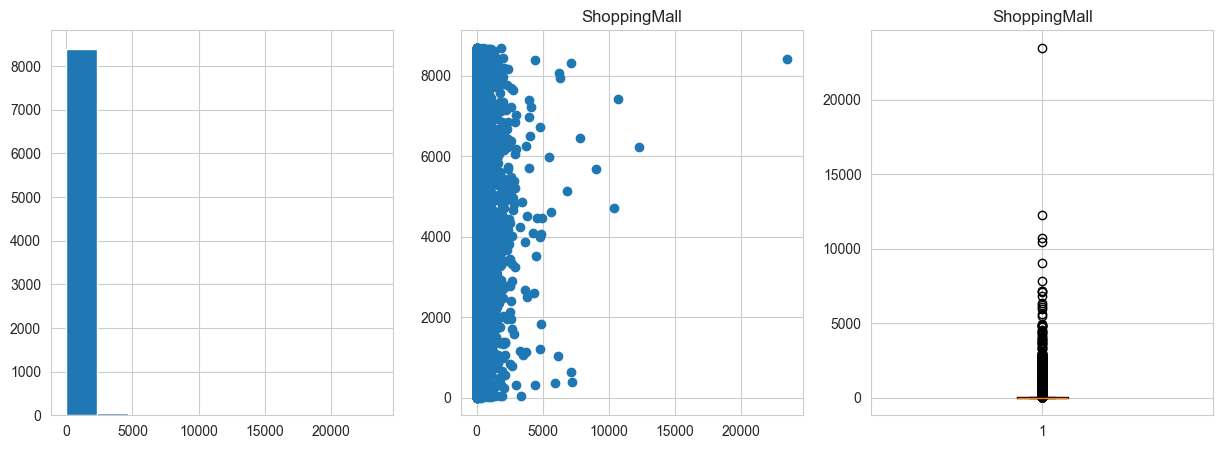

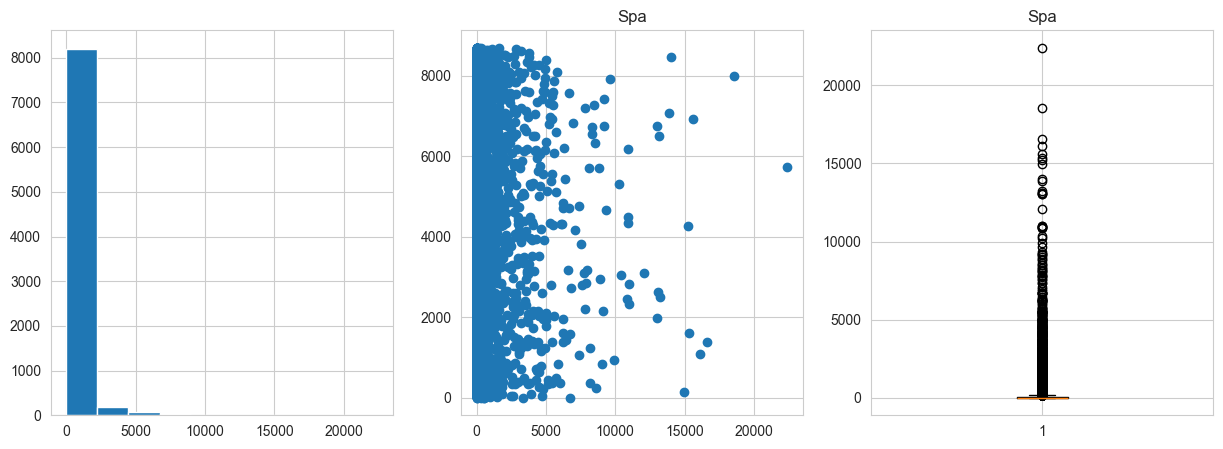

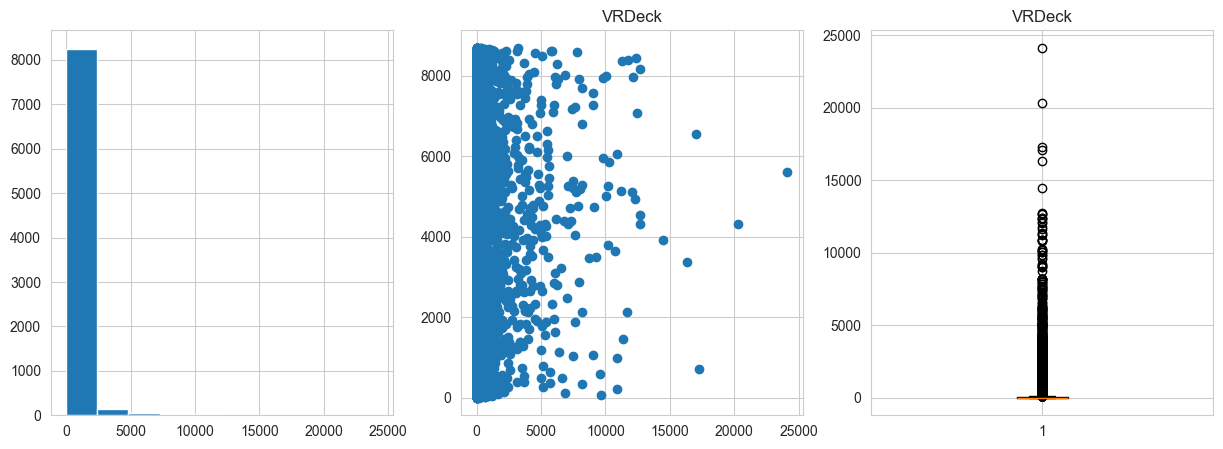

In [6]:
for num_col in df.select_dtypes(include=[np.float64]):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax.flat[0].hist(df[num_col])
    ax.flat[1].scatter(df[num_col], df.index)
    ax.flat[2].boxplot(df[~df[num_col].isnull()][num_col].to_list())
    for id in range(1, 3):
        ax.flat[id].set_title(f'{num_col}')
    plt.show()

Notes:

- There are outliers which should be removed.

In [7]:
numeric_df = df.select_dtypes(include=[np.float64])
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
((numeric_df > (Q3 + 1.5 * IQR))).sum()

Age               77
RoomService     1861
FoodCourt       1823
ShoppingMall    1829
Spa             1788
VRDeck          1809
dtype: int64

Notes:

- Removing based on the IQR will remove too many items. Instead, let's remove them manually.

In [8]:
df = df[
    (df['RoomService'] < 9_000) & 
    (df['FoodCourt'] < 20_000) &
    (df['ShoppingMall'] < 8_000) &
    (df['Spa'] < 15_000) &
    (df['VRDeck'] < 14_000)
]  

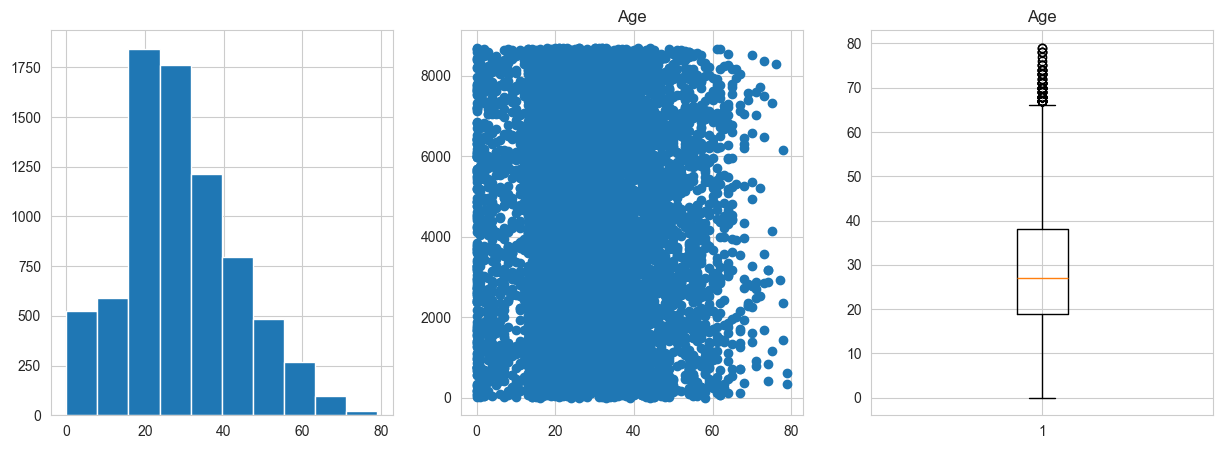

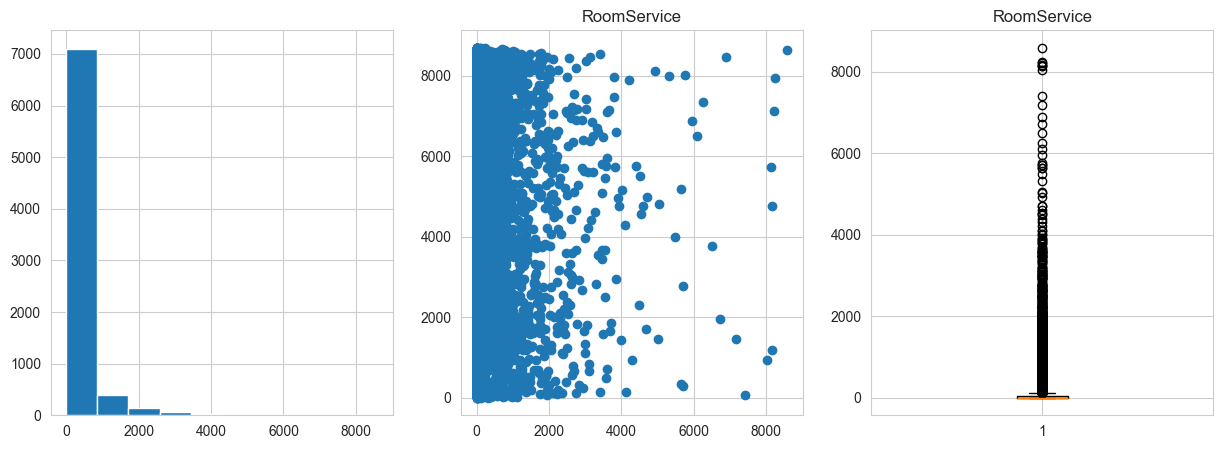

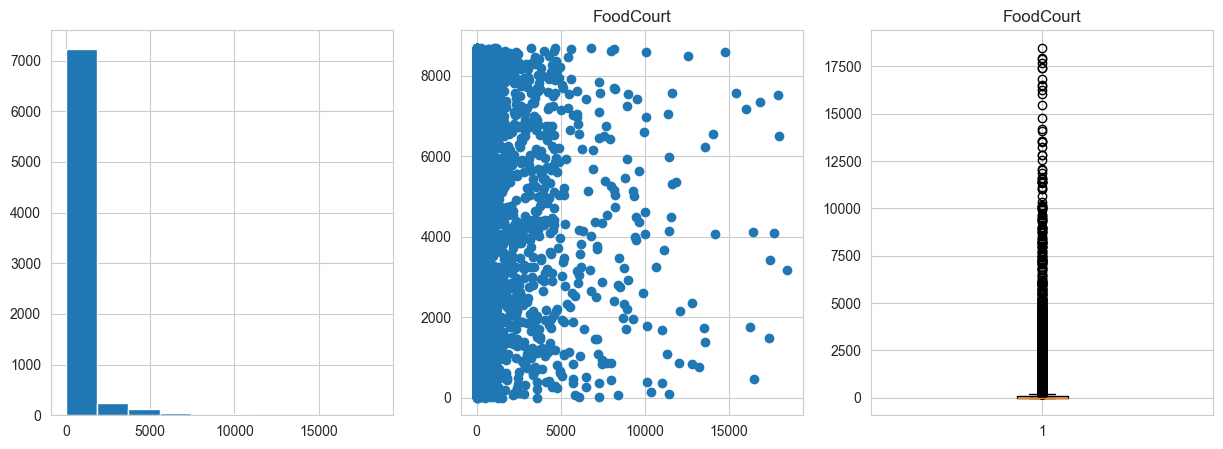

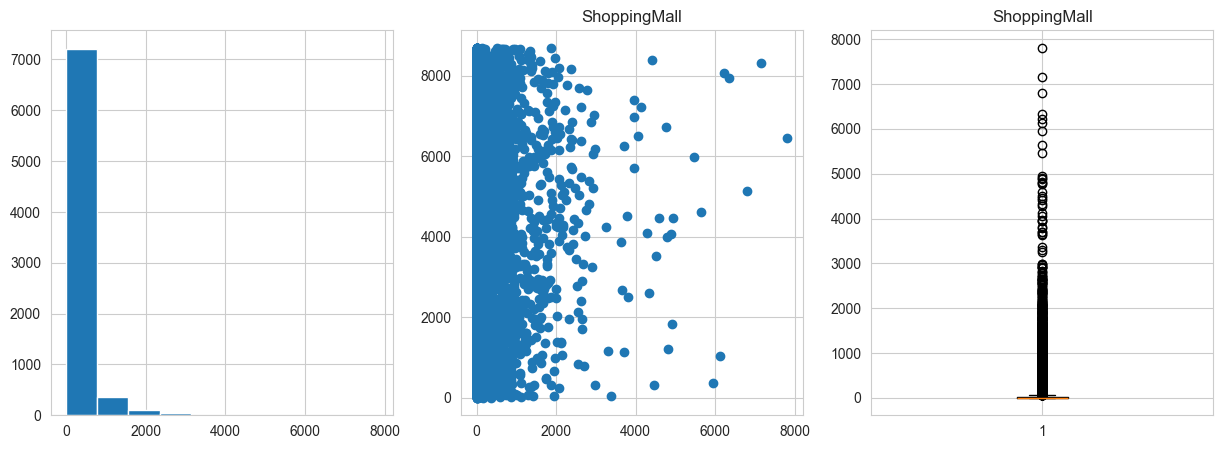

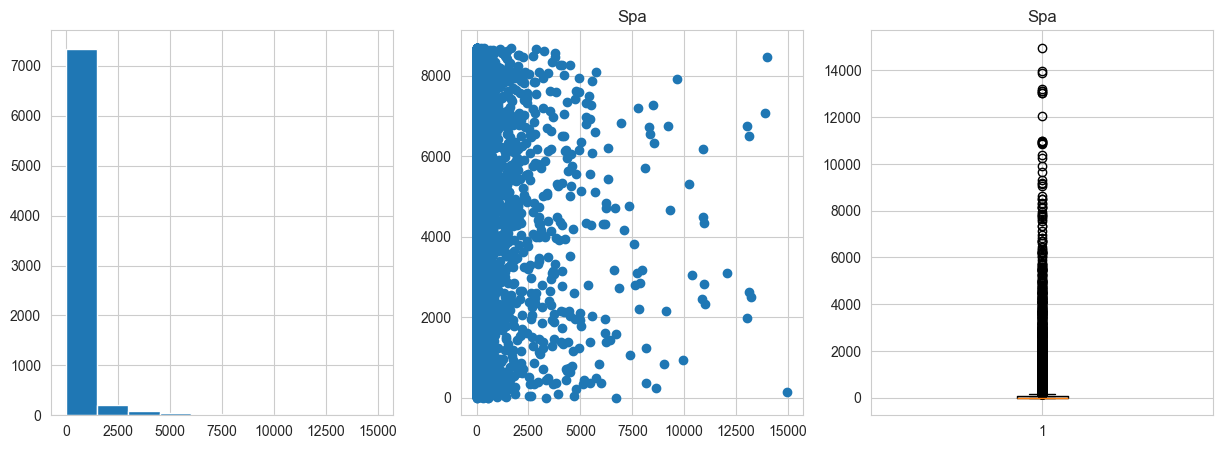

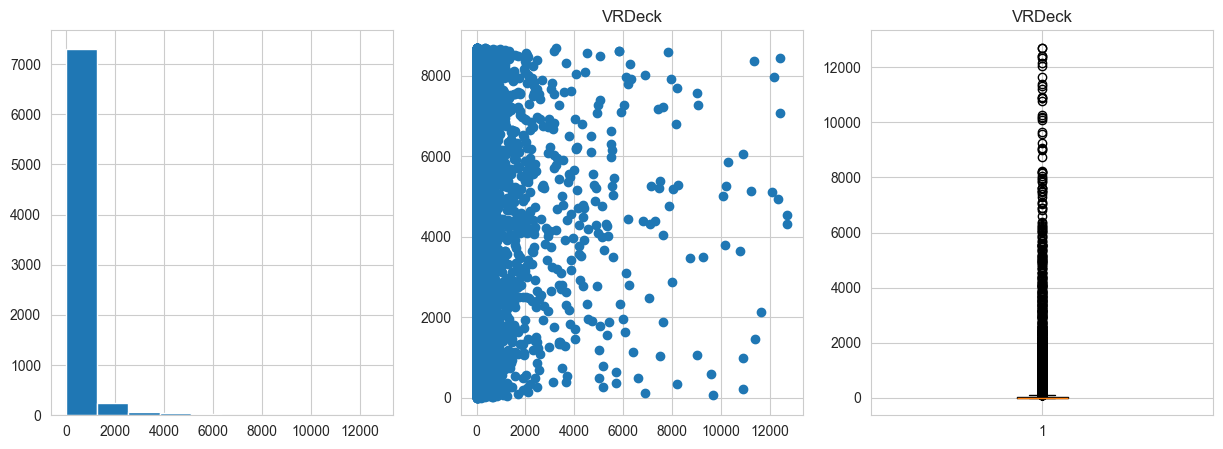

In [9]:
for num_col in df.select_dtypes(include=[np.float64]):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax.flat[0].hist(df[num_col])
    ax.flat[1].scatter(df[num_col], df.index)
    ax.flat[2].boxplot(df[~df[num_col].isnull()][num_col].to_list())
    for id in range(1, 3):
        ax.flat[id].set_title(f'{num_col}')
    plt.show()

In [10]:
for num_col in df.select_dtypes(include=[np.float64]):
    print(f'{num_col}: {len(df[df[num_col].isnull()])} NaNs')

Age: 165 NaNs
RoomService: 0 NaNs
FoodCourt: 0 NaNs
ShoppingMall: 0 NaNs
Spa: 0 NaNs
VRDeck: 0 NaNs


Notes:

- Filling NaN values with samples from the distribution of the 'Age' column to preserve the variance of the data.

In [11]:
mean_age = df['Age'].mean()
std_age = df['Age'].std()
df.loc[df['Age'].isnull(), 'Age'] = np.random.normal(mean_age, std_age, df['Age'].isnull().sum())

Notes:

- The 'Cabin' column can be split into 3 values - deck, cabin number and side.
- The 'VIP' and 'CryoSleep' columns can be converted into bool instead of object.

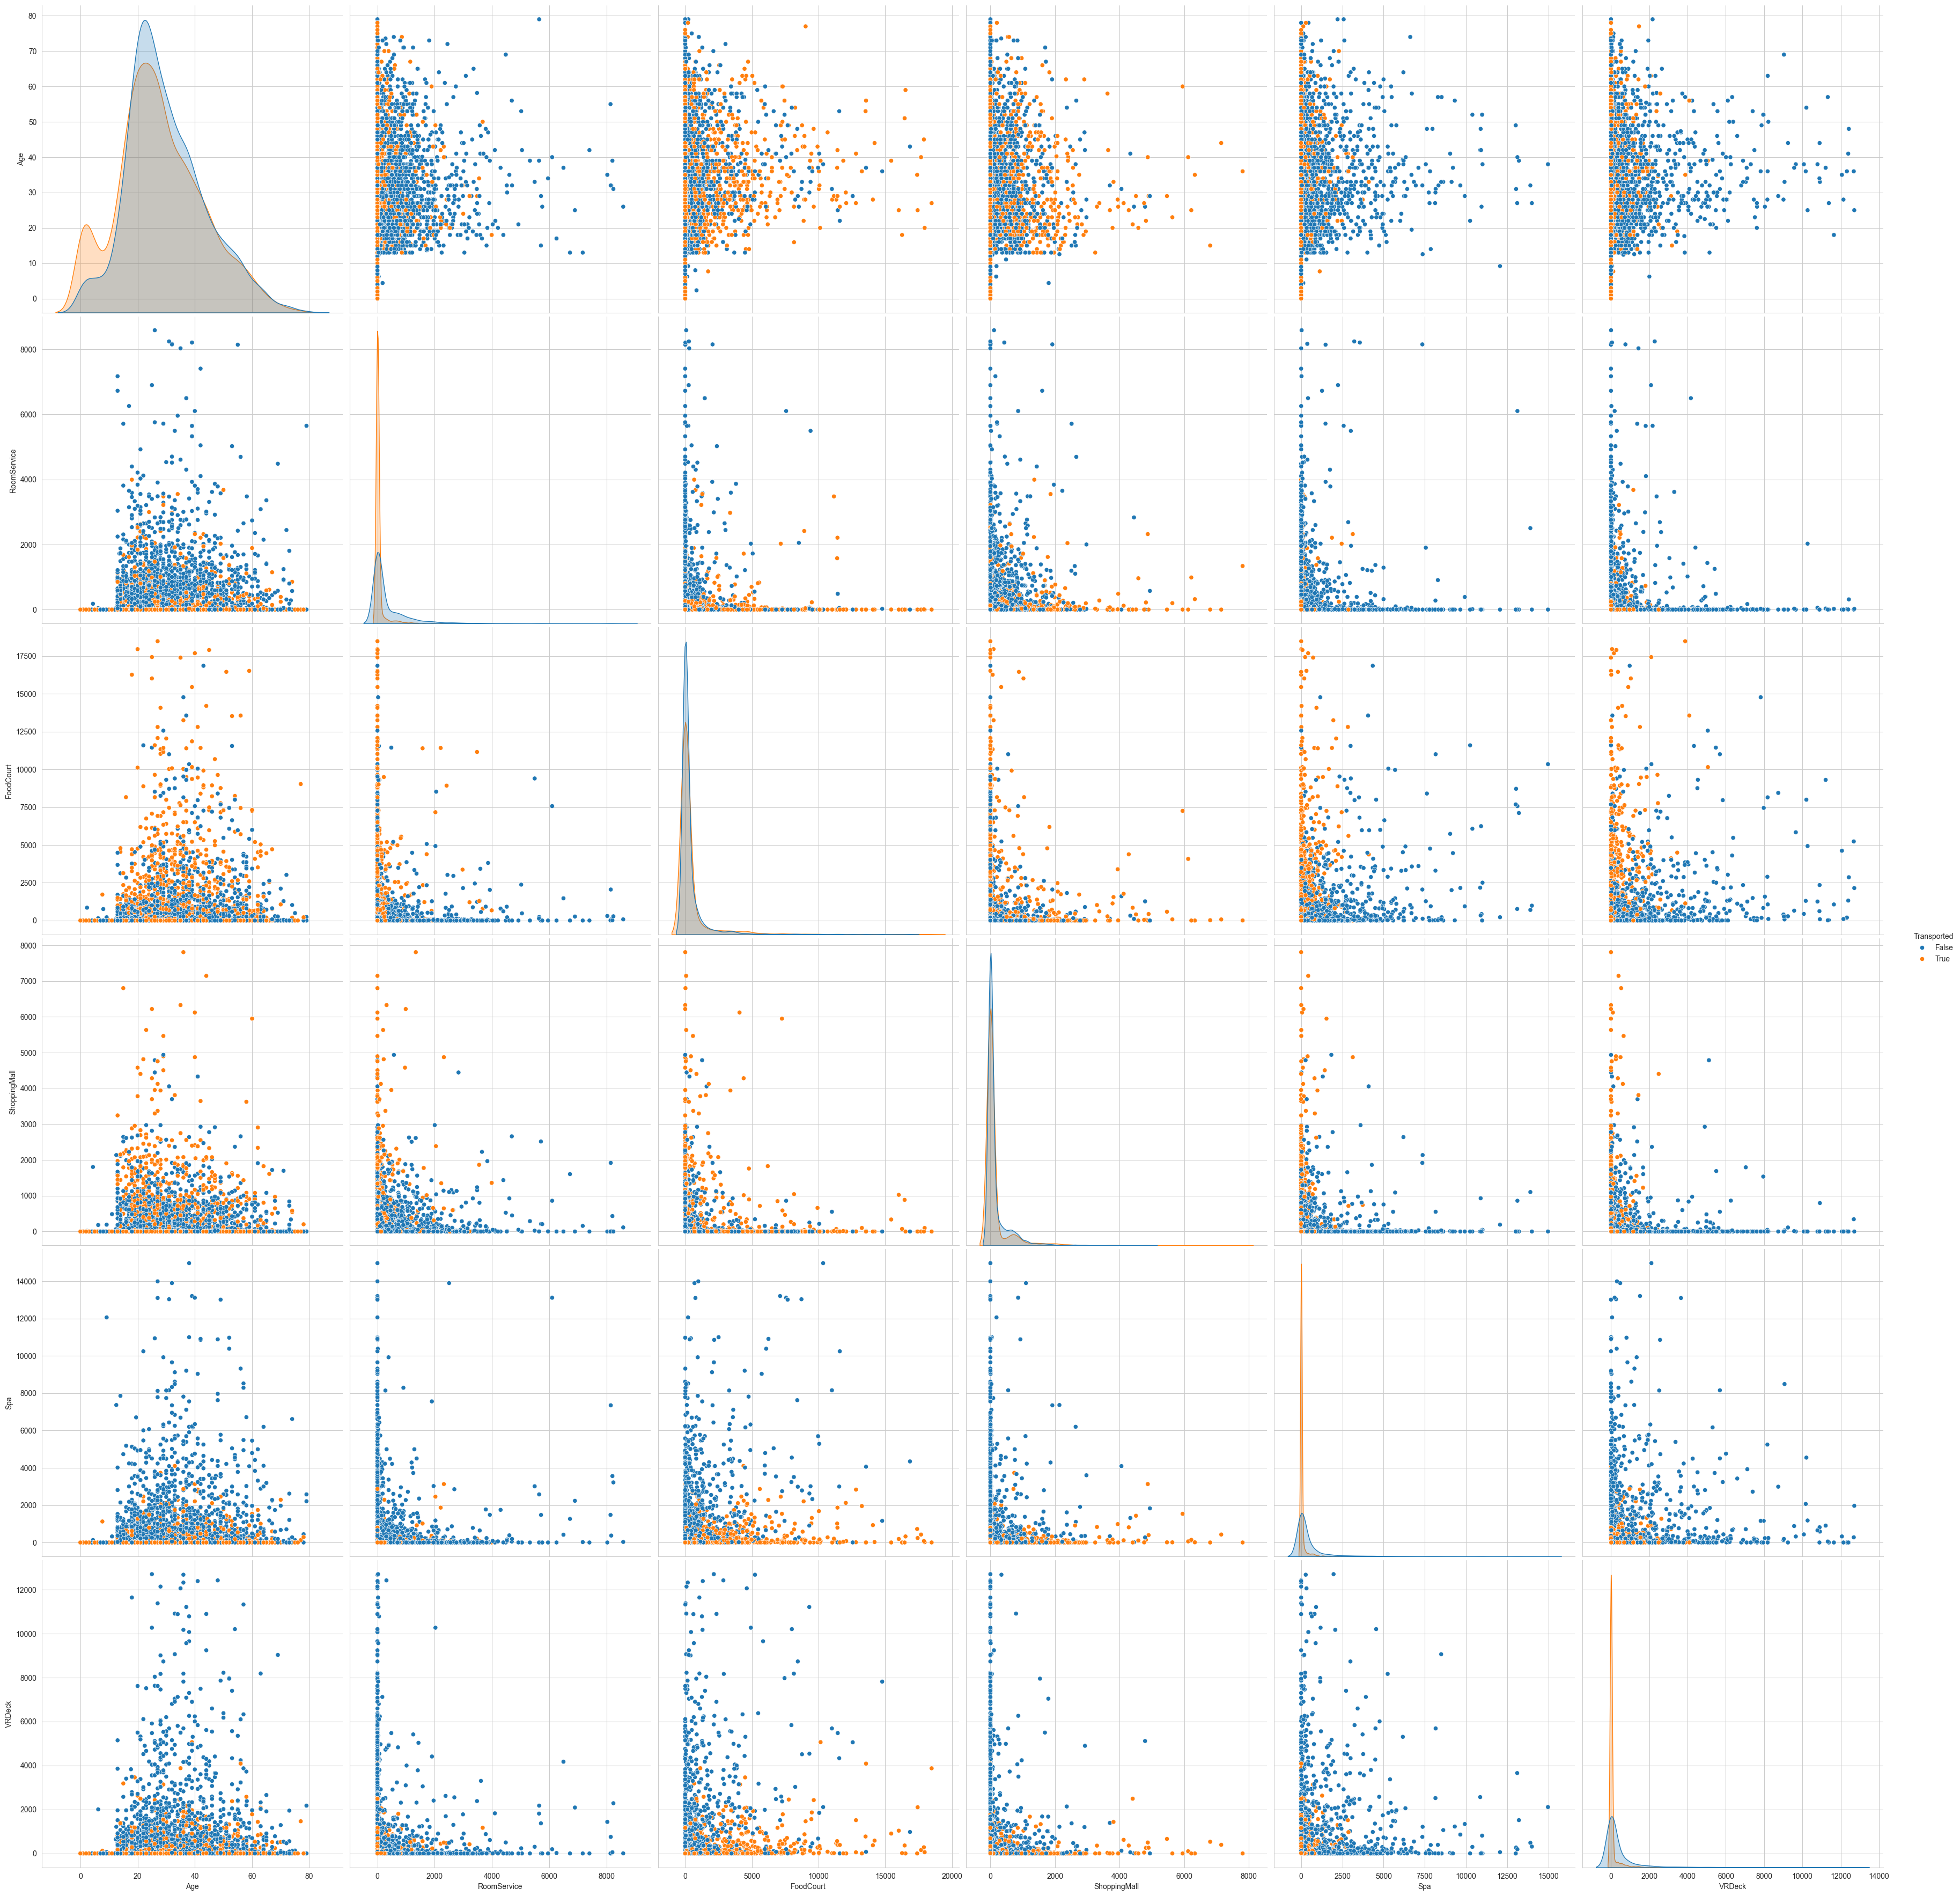

In [12]:
columns = df.select_dtypes(include=[np.float64])
sns.pairplot(
    df[df.select_dtypes(include=[np.float64]).columns.to_list() + ['Transported']], 
    hue='Transported',
    diag_kind='kde',
    height=6
)
plt.show()

Notes:

- The passengers who spend more on spa and VR deck tend *not* to be transported.
- The passengers who spend more on food and shopping tend to be transported.

In [13]:
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)

In [14]:
df.drop('Cabin', axis=1, inplace=True)

In [15]:
df.head()

HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0     Europa     False  TRAPPIST-1e  39.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  24.0  False        109.0        9.0   
2     Europa     False  TRAPPIST-1e  58.0   True         43.0     3576.0   
3     Europa     False  TRAPPIST-1e  33.0  False          0.0     1283.0   
4      Earth     False  TRAPPIST-1e  16.0  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported Deck Num Side  
0           0.0     0.0     0.0        False    B   0    P  
1          25.0   549.0    44.0         True    F   0    S  
2           0.0  6715.0    49.0        False    A   0    S  
3         371.0  3329.0   193.0        False    A   0    S  
4         151.0   565.0     2.0         True    F   1    S

Notes:

- Let's convert the 'Num' column to float and fill the missing values.

In [16]:
df['Num'] = df['Num'].astype(np.float64)

In [17]:
mean_age = df['Num'].mean()
std_age = df['Num'].std()
df.loc[df['Num'].isnull(), 'Num'] = np.random.normal(mean_age, std_age, df['Num'].isnull().sum())

In [18]:
for column in df:
    unique_values = df[column].unique()
    count_unique_values = len(unique_values)
    if count_unique_values < 10:
        print(f'{column:15}  {count_unique_values:5} | {unique_values}')

HomePlanet           4 | ['Europa' 'Earth' 'Mars' nan]
CryoSleep            3 | [False True nan]
Destination          4 | ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP                  3 | [False True nan]
Transported          2 | [False  True]
Deck                 9 | ['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
Side                 3 | ['P' 'S' nan]


Notes:
- We can run bivariate analysis for the categorical variables.

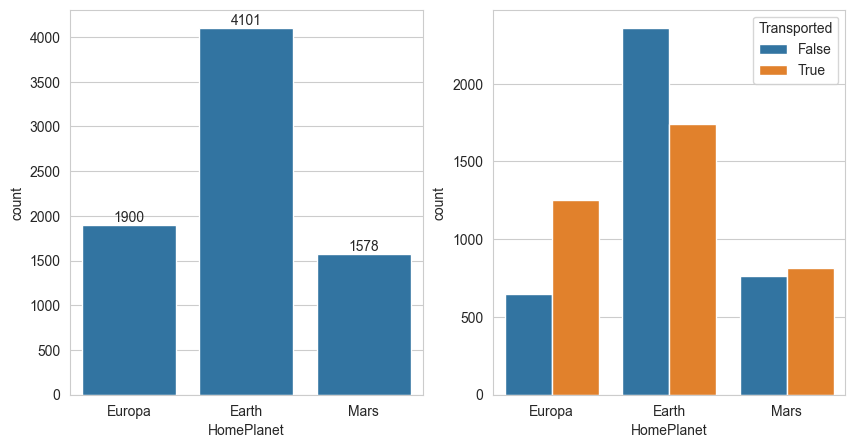

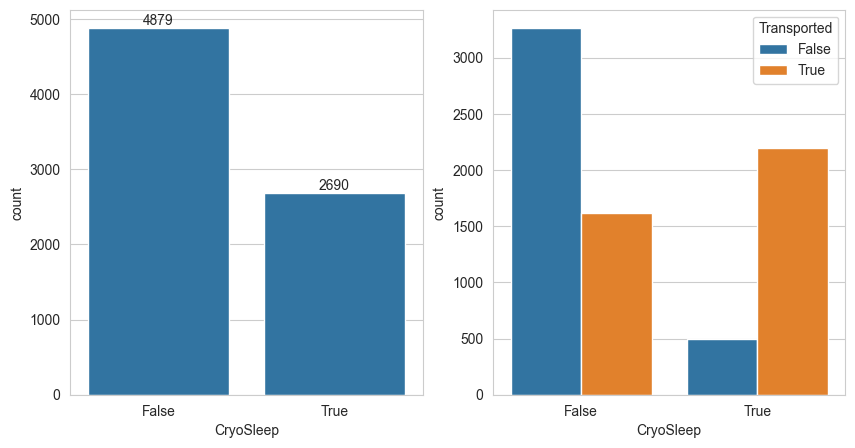

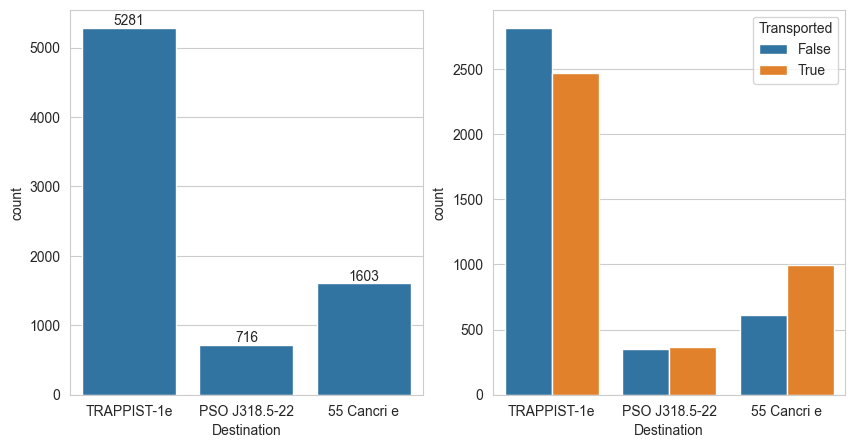

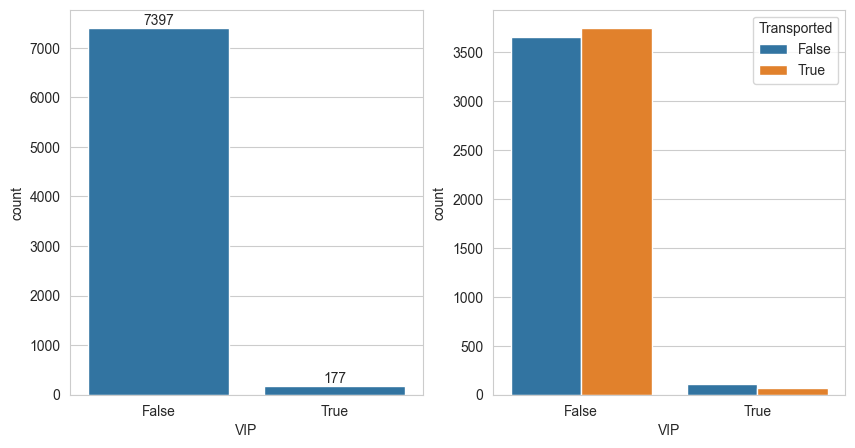

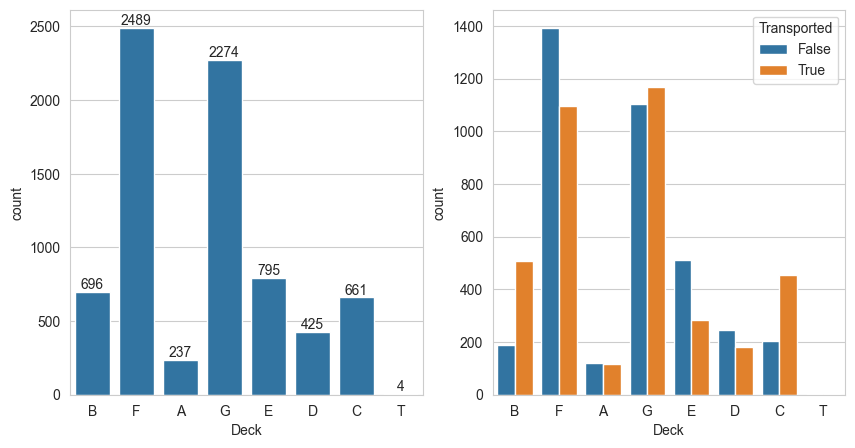

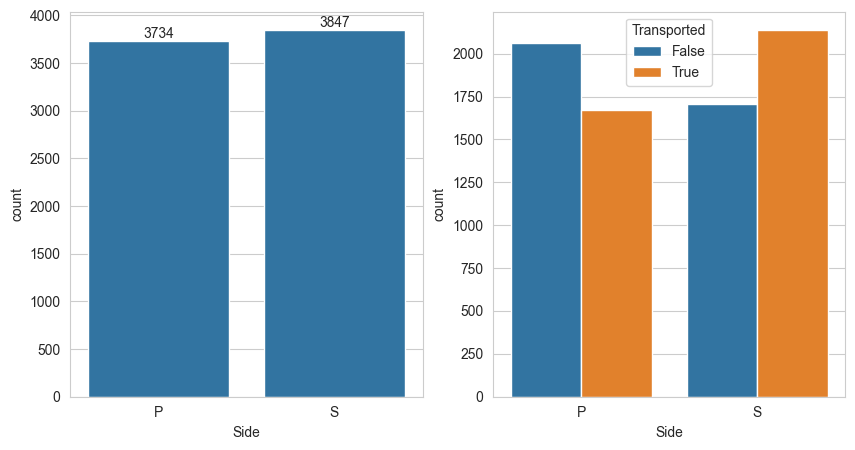

In [19]:
for column in df:
    if column != 'Transported':
        unique_values = df[column].unique()
        count_unique_values = len(unique_values)
        
        if count_unique_values < 10:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            
            c_plot = sns.countplot(data=df, x=column, ax=ax.flat[0])
            c_plot.bar_label(c_plot.containers[0])
    
            p = sns.countplot(data=df, x=column, hue='Transported', ax=ax.flat[1])
            plt.show()

Notes:

- The transported passengers seem evenly distributed among the different values of the categorical columns.
- The 'VIP' category is imbalanced.

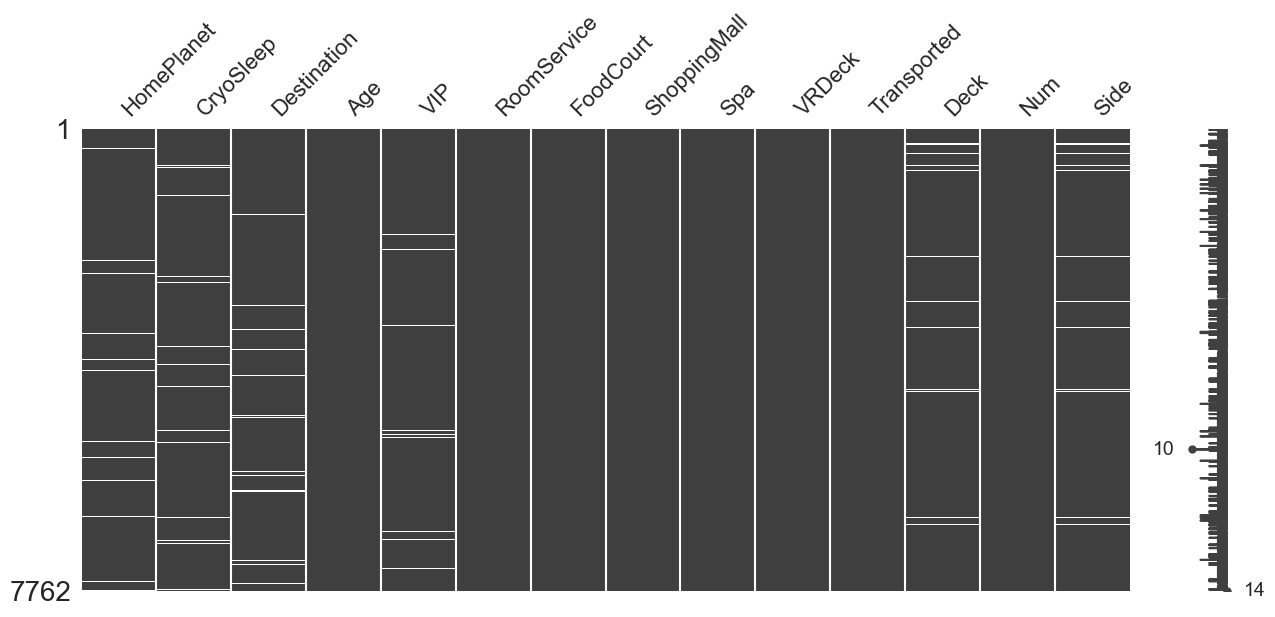

In [20]:
missingno.matrix(df, figsize = (15,6))
plt.show()

Notes:

- The categorical columns contain missing values.

In [21]:
def keep_distribution_fill(series):
    na_mask = pd.isnull(series)
    n_null = na_mask.sum()
    fill_values = series[~na_mask].sample(n=n_null, replace=True, random_state=13)
    fill_values.index = series.index[na_mask]
    return series.fillna(fill_values)

In [22]:
df.select_dtypes(include=['object']).isnull().sum()

HomePlanet     183
CryoSleep      193
Destination    162
VIP            188
Deck           181
Side           181
dtype: int64

In [ ]:
for cat_col in df.select_dtypes(include=['object']):
    df[cat_col] = keep_distribution_fill(df[cat_col])

In [24]:
df.select_dtypes(include=['object']).isnull().sum()

HomePlanet     0
Destination    0
Deck           0
Side           0
dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7762 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    7762 non-null   object 
 1   CryoSleep     7762 non-null   bool   
 2   Destination   7762 non-null   object 
 3   Age           7762 non-null   float64
 4   VIP           7762 non-null   bool   
 5   RoomService   7762 non-null   float64
 6   FoodCourt     7762 non-null   float64
 7   ShoppingMall  7762 non-null   float64
 8   Spa           7762 non-null   float64
 9   VRDeck        7762 non-null   float64
 10  Transported   7762 non-null   bool   
 11  Deck          7762 non-null   object 
 12  Num           7762 non-null   float64
 13  Side          7762 non-null   object 
dtypes: bool(3), float64(7), object(4)
memory usage: 750.4+ KB


Notes:
- The dataframe contains no missing values.

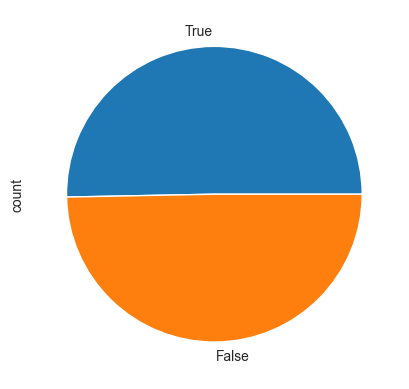

In [26]:
df['Transported'].value_counts(dropna=False).plot(kind='pie')
plt.show()

Notes:
- There is no class imbalance in the output classes.

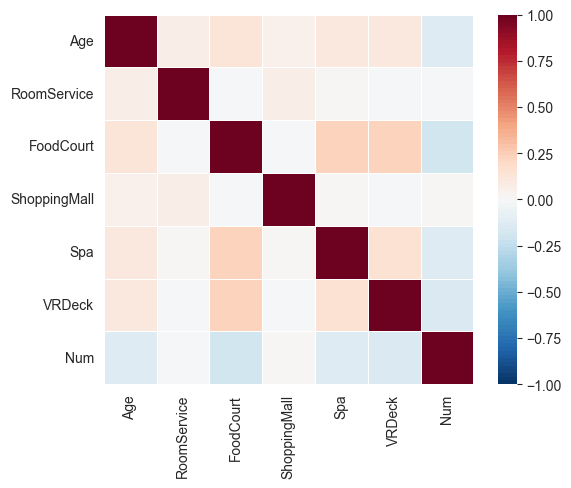

In [27]:
sns.heatmap(
    df.select_dtypes(include=['float64']).corr(), 
    vmin=-1, 
    vmax=1, 
    square=True, 
    cmap=sns.color_palette('RdBu_r', 100),
    linewidths=.5
)
plt.show()

Notes:

- There are no highly correlated numerical predictors.

In [28]:
cat_cols = df.select_dtypes(include=['object']).columns.to_list()
dummies = pd.get_dummies(df[cat_cols])
df = df.drop(cat_cols, axis=1)
df = pd.concat([df, dummies], axis=1)

In [29]:
df.head()

CryoSleep   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  \
0      False  39.0  False          0.0        0.0           0.0     0.0   
1      False  24.0  False        109.0        9.0          25.0   549.0   
2      False  58.0   True         43.0     3576.0           0.0  6715.0   
3      False  33.0  False          0.0     1283.0         371.0  3329.0   
4      False  16.0  False        303.0       70.0         151.0   565.0   

   VRDeck  Transported  Num  ...  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  \
0     0.0        False  0.0  ...   False    True   False   False   False   
1    44.0         True  0.0  ...   False   False   False   False   False   
2    49.0        False  0.0  ...    True   False   False   False   False   
3   193.0        False  0.0  ...    True   False   False   False   False   
4     2.0         True  1.0  ...   False   False   False   False   False   

   Deck_F  Deck_G  Deck_T  Side_P  Side_S  
0   False   False   False    True   False  
1    True   False   False   False    True  
2   False   False   False   False    True  
3   False   False   False   False    True  
4    True   False   False   False    True  

[5 rows x 26 columns]

In [30]:
for col in df.select_dtypes(include=['bool']):
    df[col] = df[col].astype(np.int64)

Notes:

- After the categorical values have been one hot encoded, let's look at the correlation between them.

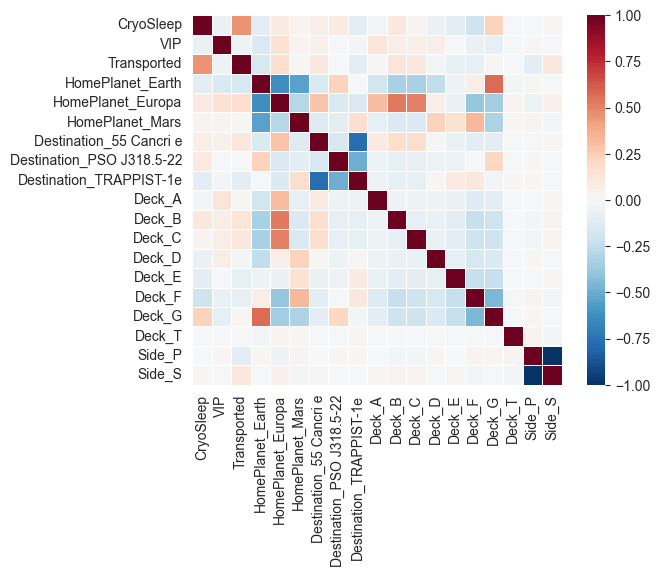

In [31]:
sns.heatmap(
    df.select_dtypes(include=['int64']).corr(), 
    vmin=-1, 
    vmax=1, 
    square=True, 
    cmap=sns.color_palette('RdBu_r', 100),
    linewidths=.5
)
plt.show()

Notes:

- As expected, there is a high correlation between 'CryoSleep' and 'Transported'.

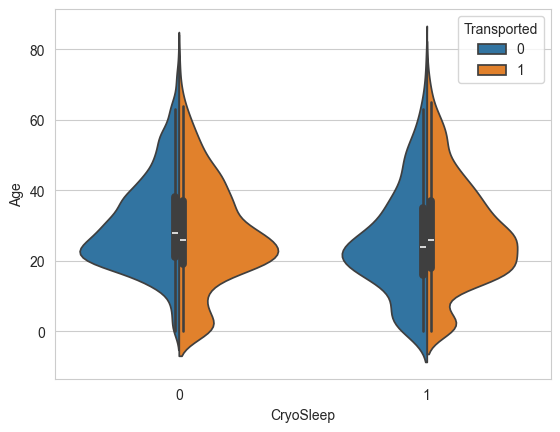

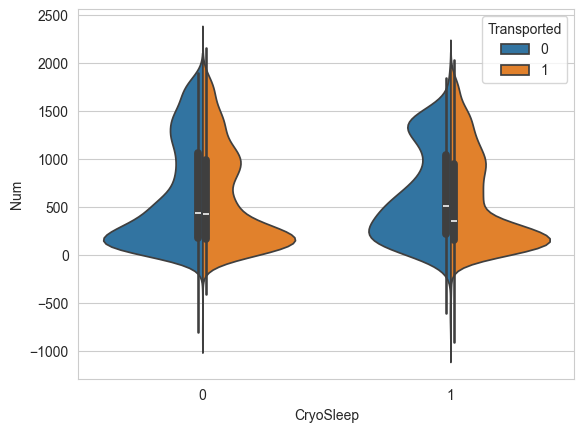

In [32]:
for num_col in ['Age', 'Num']:
    sns.violinplot(x='CryoSleep', y=num_col, hue='Transported', data=df, split=True)
    plt.show()

Notes:

- Younger passengers in cryosleep are usually transported.